A gaussian process model is a powerful and flexible regression (and classification) model. 
We use a Gaussian Process with matern kernel to model the house prices. 

In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import math
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic


def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

def catcheck(df):
    iscat = np.zeros(df.shape[1])
    for c in range(df.shape[1]):
        if df.dtypes[c] == 'object':
            iscat[c] = 1
        else:
            iscat[c] = 0
    catdf = pd.DataFrame({'variable': df.columns, 'iscat': iscat})
    havecat = catdf[catdf.iscat == 1]
    catcolumn = havecat.variable.tolist()
    return catcolumn  

def NAcheck(df):
    isna = np.zeros(df.shape[1])
    for c in range(df.shape[1]):
        isna[c] = df.iloc[:, c].isnull().values.any()
            # For each columns, it return "True" if they have NaN.
    nandf = pd.DataFrame({'variable': df.columns, 'isna': isna})
    havenan = nandf[nandf.isna == 1]
    NAcolumn = havenan.variable.tolist()
    return NAcolumn

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
y_log = np.log1p(train["SalePrice"].values)
train1 = train.drop(["Id","SalePrice"], axis=1)
test1 = test.drop("Id", axis=1)

collist = set(NAcheck(train1) + NAcheck(test1))
train1 = train1.drop(collist, axis = 1)
test1 = test1.drop(collist, axis = 1)

train1 = train1.drop(catcheck(train1), axis = 1)
test1 = test1.drop(catcheck(test1), axis = 1)

print(train1.columns)

X = train1.values
X_test = test1.values

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


In [8]:
kernel = 1.0**2 * Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=0.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=5e-9, optimizer='fmin_l_bfgs_b', 
                                n_restarts_optimizer=0, normalize_y=False, copy_X_train=True,
                                random_state=2016)

clf = Pipeline([('scaler', StandardScaler()), ('gp', gp)])     

y_log_centered = y_log - y_log.mean()
y_pred = cross_val_predict(clf, X, y_log_centered, cv=5, n_jobs=-1)
y = np.expm1(y_log)
y_pred = np.expm1(y_pred + y_log.mean())
score = rmsle(y,y_pred)
print(score) 

0.1459496865771487


In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

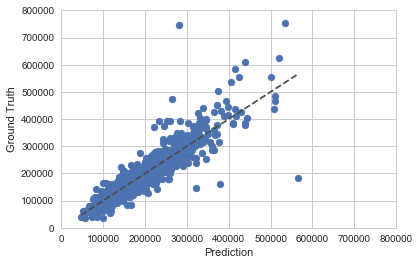

In [10]:
plt.scatter(y_pred, y)
plt.plot([min(y_pred),max(y_pred)], [min(y_pred),max(y_pred)], ls="--", c=".3")
plt.xlim([0,800000])
plt.ylim([0,800000])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.show()

Now predict

In [11]:
clf.fit(X,y_log_centered)
prediction = clf.predict(X_test)

In [12]:
print(clf.steps[1][1].kernel_)

1.38**2 * Matern(length_scale=198, nu=0.5)


In [13]:
prediction = np.expm1(prediction + y_log.mean())

In [16]:
print(prediction)
print(score)

[ 126915.93124026  149372.53746807  183210.66293316 ...,  160993.95731223
  127673.62508873  229966.30103025]
0.1459496865771487
